In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mt
import matplotlib.pyplot as plt
import tensorflow as tsf
import tensorflow.keras as keras
import os
import cv2

C:\Users\mitul\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mitul\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mitul\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mitul\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [3]:
 #Since only 2 folders(without and with mask), lets identify then and label them  as 0,1
dp='dataset'
cat = os.listdir(dp)
lb=[i for i in range(len(cat))]
lb_dict=dict(zip(cat,lb))

lb_dict

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset'

In [ ]:
dt=[]   #List for saving all the grayscale resized images
z=[]   #List for saving the lables
#converting the image to greyscale and resizing it
for category in cat:
    fp=os.path.join(dp,category)
    inm= os.listdir(fp)
    
    for img_name in inm:
        ip=os.path.join(fp,img_name)
        img=cv2.imread(ip)
        
        try:
            g=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    #Coverting the image into gray scale
            rz=cv2.resize(g,(100,100)) #resizing the gray scale into 100X100, since we need a fixed common size for all the images in the dataset
            dt.append(rz)
            z.append(lb_dict[category])      #appending the image and the label(categorized) into the list (dataset)
        
        except Exception as e:
            print('Exception:',e)          #if any exception rasied, the exception will be printed here. And pass to the next image

            
            
dt=np.array(dt)/255.0
dt=np.reshape(dt,(dt.shape[0],100,100,1))
z=np.array(z)

from keras.utils import np_utils

net=np_utils.to_categorical(z)      # Converting into categorical array sice the ouput layer neurons in the DL 
                                            #model will have categorical wise only (with mas and without mask)
    
    

np.save('data',dt)
np.save('target',net)

In [6]:
#Creating the architecture

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=dt.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()



NameError: name 'dt' is not defined

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#SPLITTING THE DATA INTO TEST AND TRAIN
from sklearn.model_selection import train_test_split
train_data,test_data,train_z,test_z=train_test_split(dt,z,test_size=0.1,random_state=45)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
  'model-{epoch:03d}.model',
  monitor='val_loss',
  verbose=0,
  save_best_only=True,
  mode='auto')

history=model.fit(
  train_data,
  train_z,
  epochs=25,
  callbacks=[checkpoint],
  validation_split=0.2)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 990 samples, validate on 248 samples
Epoch 1/25
990/990 [==============================] - 25s 25ms/sample - loss: 0.6832 - acc: 0.5606 - val_loss: 0.6521 - val_acc: 0.5968
Epoch 2/25
768/990 [======================>.......] - ETA: 3s - loss: 0.6468 - acc: 0.6367

In [5]:
#SEEING THE EXACRT LOSS AND THE ACCURACY
print(model.evaluate(test_data,test_z))

NameError: name 'test_data' is not defined

In [129]:
#FINALLY WE WILL TAKE THE FIRST 10 IMAGES OF TEST DATA SET AND WOULD PREDICT
#IF THERE IS A MASK OR NOT AND WOULD COMPARE THAT WITH PICTURE
sample_pics=test_data[:10]
y_final=[]
y=model.predict_classes(sample_pics)
for i in y:
    y_final.append(i[0])
y_final
final_dict={}
for i in range(len(y_final)):
    if y_final[i]==1:
        final_dict[i]="PREDICTED WEARING A MASK"
    else:
        final_dict[i]="PREDICTED NOT WEARING A MASK"
print(final_dict)
#CREATING A FINAL DICTIONARY TELLING IF THAT PARTICULAR INDEX FROM DATA SET IS WEARING A MASK OR NOT ACCORDING TO PREDICTION

{0: 'PREDICTED NOT WEARING A MASK', 1: 'PREDICTED NOT WEARING A MASK', 2: 'PREDICTED WEARING A MASK', 3: 'PREDICTED WEARING A MASK', 4: 'PREDICTED NOT WEARING A MASK', 5: 'PREDICTED NOT WEARING A MASK', 6: 'PREDICTED NOT WEARING A MASK', 7: 'PREDICTED NOT WEARING A MASK', 8: 'PREDICTED WEARING A MASK', 9: 'PREDICTED WEARING A MASK'}


AxesImage(54,36;334.8x217.44)


      PREDICTED NOT WEARING A MASK


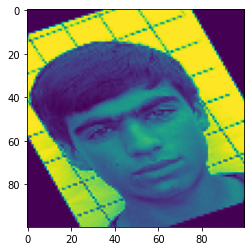

In [130]:
print(plt.imshow(test_data[0].reshape(100,100)))
print("\n\n     ",final_dict[0])

AxesImage(54,36;334.8x217.44)


      PREDICTED NOT WEARING A MASK


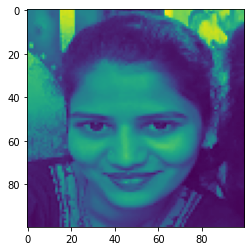

In [131]:
print(plt.imshow(test_data[1].reshape(100,100)))
print("\n\n     ",final_dict[1])

AxesImage(54,36;334.8x217.44)


      PREDICTED WEARING A MASK


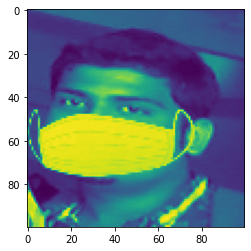

In [132]:
print(plt.imshow(test_data[2].reshape(100,100)))
print("\n\n     ",final_dict[2])

In [2]:
print(plt.imshow(test_data[3].reshape(100,100)))
print("\n\n    ",final_dict[3])

NameError: name 'plt' is not defined

AxesImage(54,36;334.8x217.44)


      PREDICTED NOT WEARING A MASK


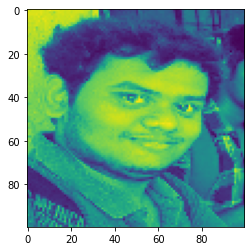

In [134]:
print(plt.imshow(test_data[4].reshape(100,100)))
print("\n\n     ",final_dict[4])

AxesImage(54,36;334.8x217.44)


      PREDICTED NOT WEARING A MASK


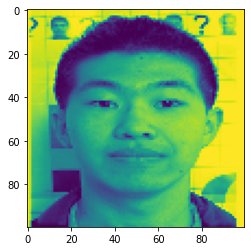

In [135]:
print(plt.imshow(test_data[5].reshape(100,100)))
print("\n\n     ",final_dict[5])


AxesImage(54,36;334.8x217.44)


      PREDICTED NOT WEARING A MASK


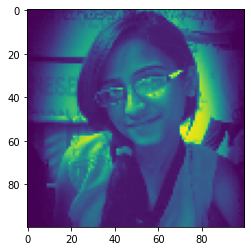

In [136]:
print(plt.imshow(test_data[6].reshape(100,100)))
print("\n\n     ",final_dict[6])

AxesImage(54,36;334.8x217.44)


      PREDICTED NOT WEARING A MASK


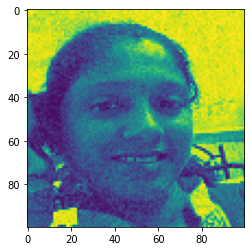

In [137]:
print(plt.imshow(test_data[7].reshape(100,100)))
print("\n\n     ",final_dict[7])

In [1]:
print(plt.imshow(test_data[8].reshape(100,100)))
print("\n\n     ",final_dict[8])

NameError: name 'plt' is not defined

AxesImage(54,36;334.8x217.44)


      PREDICTED WEARING A MASK


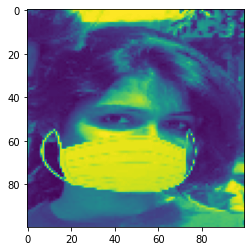

In [139]:
print(plt.imshow(test_data[9].reshape(100,100)))
print("\n\n     ",final_dict[9])